# Time-varying Signals Recovery via Graph Neural Networks

In [1]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
import scipy.io as sio
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import torch
from numpy import radians, sin, cos, arcsin, sqrt, abs

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## utils
def haversine_distance(p1, p2):
  """
  Tính khoảng cách Haversine giữa hai tọa độ.

  Args:
    lat1: Vĩ độ của điểm đầu tiên (độ).
    lon1: Kinh độ của điểm đầu tiên (độ).
    lat2: Vĩ độ của điểm thứ hai (độ).
    lon2: Kinh độ của điểm thứ hai (độ).

  Returns:
    Khoảng cách (km).
  """
  lat1 = p1[0]
  lon1 = p1[1]
  lat2 = p2[0]
  lon2 = p2[1]
  R = 6371.01  # Bán kính Trái Đất (km)

  d_lat = radians(lat2 - lat1)
  d_lon = radians(lon2 - lon1)

  a = sin(d_lat/2)**2 + cos(lat1) * cos(lat2) * sin(d_lon/2)**2
  c = 2 * arcsin(sqrt(abs(a)))
  return R * c

class SobolevLoss(nn.Module):
    def __init__(self, mse_weight, sobolev_weight):
        super(SobolevLoss, self).__init__()
        self.mse_weight = mse_weight
        self.sobolev_weight = sobolev_weight

    def forward(self, predicted, target, laplacian_matrix):
        # Tính toán MSE loss
        mse_loss = torch.mean((predicted - target)**2)

        # Tính toán Sobolev regularization term
        sobolev_loss = torch.trace(torch.matmul(predicted.t(), torch.matmul(laplacian_matrix, predicted)))

        # Tổng hợp hàm mất mát: MSE term cộng với Sobolev regularization term
        loss = self.mse_weight * mse_loss + self.sobolev_weight * sobolev_loss

        return loss

## Build model

In [3]:
class TimeGNN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dim, num_layers):
        super().__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.convs = nn.ModuleList()
        # Input layer
        self.convs.append(ChebConv(in_dim, hidden_dim, K=2))
        
        # Hidden layers
        for _ in range(1, num_layers - 1):
            self.convs.append(ChebConv(hidden_dim, hidden_dim, K=2))
        
        # Output layer
        self.convs.append(ChebConv(hidden_dim, hidden_dim, K=2))

        self.output_layer = nn.Linear(hidden_dim, out_dim)

    def forward(self, graph, x):
        # Truyền tin GNN
        edge_index = torch.tensor(np.array(graph.edges).T) 
        for gnn_layer in self.convs:
            x = gnn_layer(x, edge_index)

        # Đầu ra
        x = self.output_layer(x)

        return x

## Train with PM2.5 data

In [4]:
## Read data
data = sio.loadmat('data/PM2_5_concentration.mat')
pm25 = data['myDataPM']
position = data['Position']

### Build graph

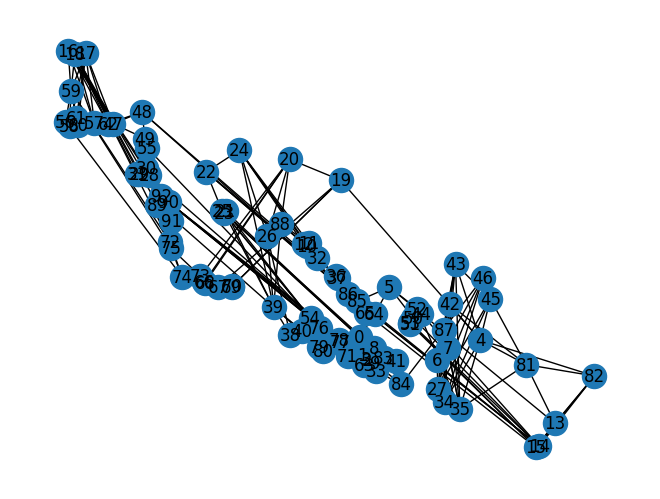

In [5]:
# Giá trị k
k = 5

# Bán kính σ của nhân Gaussian
sigma = 0.5

# Tạo đồ thị
G = nx.Graph()

# Thêm các điểm dữ liệu vào đồ thị
for i in range(len(position)):
    G.add_node(i, pos=position[i])

# Tính toán khoảng cách
distances = np.zeros((len(position), len(position)))
for i in range(len(position)):
    for j in range(len(position)):
        distances[i][j] = haversine_distance(position[i] , position[j])

# Xác định láng giềng
neighbors = []
for i in range(len(position)):
    neighbors.append(np.argsort(distances[i])[1:k+1])

# Tạo cạnh đồ thị
for i in range(len(position)):
    for j in neighbors[i]:
        # Trọng số của cạnh
        weight = np.exp((-distances[i][j]**2) / (2 * sigma**2))
        G.add_edge(i, j, weight=weight)

nx.draw(G, with_labels=True, pos=nx.get_node_attributes(G, 'pos'))
plt.show()

### Train model

In [6]:
epochs = 5000
in_dim = pm25.shape[1] # Kích thước mỗi node
out_dim = in_dim # kích thước đầu ra mỗi node
hidden_dim = 6 # Hay còn gọi là hidden unit [2;10]
num_layers = 2 # Số lớp ChebConv
lr = 0.1
lambda_reg = 1*10**(-4)
mse_weight = 1

## Load data
x = torch.tensor(pm25).to(torch.float)
laplacian_matrix = torch.tensor(nx.laplacian_matrix(G).toarray()).to(torch.float)

## Create model
model = TimeGNN(in_dim, out_dim,hidden_dim,num_layers)

## opt
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

## loss function
loss_fn = SobolevLoss(mse_weight, lambda_reg)

## Train model
for epoch in range(epochs):
    output = model(G,x)
    loss = loss_fn(output, x,laplacian_matrix)
    ## update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/5000, Loss: 216.6226
Epoch 2/5000, Loss: 109114.2266
Epoch 3/5000, Loss: 4150.4043
Epoch 4/5000, Loss: 11259.7236
Epoch 5/5000, Loss: 12171.9951
Epoch 6/5000, Loss: 6282.7964
Epoch 7/5000, Loss: 8415.0215
Epoch 8/5000, Loss: 14571.3135
Epoch 9/5000, Loss: 32484.5273
Epoch 10/5000, Loss: 12220.9863
Epoch 11/5000, Loss: 12457.7959
Epoch 12/5000, Loss: 8100.4272
Epoch 13/5000, Loss: 7890.9355
Epoch 14/5000, Loss: 4060.7898
Epoch 15/5000, Loss: 8466.7471
Epoch 16/5000, Loss: 1124.4822
Epoch 17/5000, Loss: 4847.9297
Epoch 18/5000, Loss: 4319.3228
Epoch 19/5000, Loss: 697.7866
Epoch 20/5000, Loss: 3169.9077
Epoch 21/5000, Loss: 3358.1401
Epoch 22/5000, Loss: 1492.4954
Epoch 23/5000, Loss: 1410.9912
Epoch 24/5000, Loss: 1596.1334
Epoch 25/5000, Loss: 1993.0398
Epoch 26/5000, Loss: 1181.0006
Epoch 27/5000, Loss: 793.1900
Epoch 28/5000, Loss: 901.0201
Epoch 29/5000, Loss: 595.9881
Epoch 30/5000, Loss: 889.9535
Epoch 31/5000, Loss: 621.6495
Epoch 32/5000, Loss: 761.9652
Epoch 33/5000, Lo

### Test model

In [11]:
## giả sử bộ dữ liệu bị mất tín hiệu ở trung tâm đo đầu tiên và ở bước thời gian thứ 6
new1 = torch.clone(x)
new1[0][5] = 0
## Create test data
test_x = torch.clone(new1) 


# Set the model to evaluation mode
model.eval()

# Pass the test dataset through the model
with torch.no_grad():
    output = model(G, test_x)

# Compare the output with the original input
reconstructed_data = output.cpu().numpy()  # Convert the tensor to numpy array
reconstructed_data = reconstructed_data.astype(np.float32)
reconstructed_data = np.round(reconstructed_data, decimals=1)

In [12]:
print('origin    :', x.numpy()[0][:10])
print('new       :', new1.numpy()[0][:10])
print('after test:',reconstructed_data[0][:10])

origin    : [16.7 23.1 27.5 28.2 31.1 28.5 18.6 30.6 23.2 22. ]
new       : [16.7 23.1 27.5 28.2 31.1  0.  18.6 30.6 23.2 22. ]
after test: [15.5 19.2 20.  25.  22.7 22.4 20.6 28.2 20.7 20.9]


## Train with sea surface temperature data

In [13]:
## Read data
data = sio.loadmat('data/sea_surface_temperature.mat')
temperaturem25 = data['Data']
position = data['Position']

### Build graph

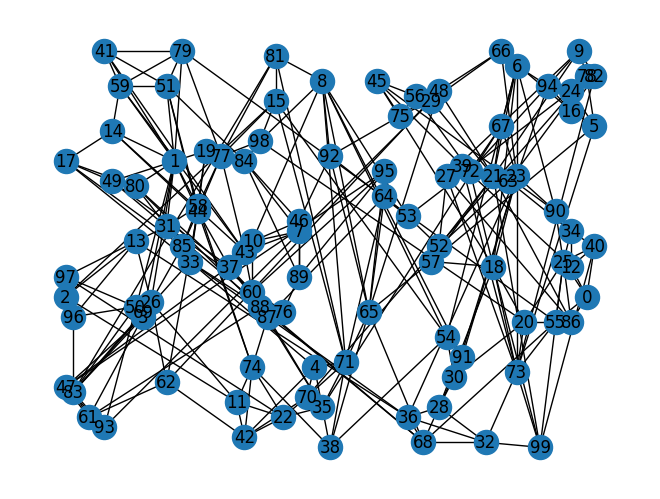

In [14]:
# Giá trị k
k = 5

# Bán kính σ của nhân Gaussian
sigma = 0.5

# Tạo đồ thị
G = nx.Graph()

# Thêm các điểm dữ liệu vào đồ thị
for i in range(len(position)):
    G.add_node(i, pos=position[i])

# Tính toán khoảng cách
distances = np.zeros((len(position), len(position)))
for i in range(len(position)):
    for j in range(len(position)):
        distances[i][j] = haversine_distance(position[i] , position[j])

# Xác định láng giềng
neighbors = []
for i in range(len(position)):
    neighbors.append(np.argsort(distances[i])[1:k+1])

# Tạo cạnh đồ thị
for i in range(len(position)):
    for j in neighbors[i]:
        # Trọng số của cạnh
        weight = np.exp((-distances[i][j]**2) / (2 * sigma**2))
        G.add_edge(i, j, weight=weight)

nx.draw(G, with_labels=True, pos=nx.get_node_attributes(G, 'pos'))
plt.show()

### Train model

In [18]:
epochs = 5000
in_dim = temperaturem25.shape[1] # Kích thước mỗi node
out_dim = in_dim # kích thước đầu ra mỗi node
hidden_dim = 6 # Hay còn gọi là hidden unit [2;10]
num_layers = 2 # Số lớp ChebConv
lr = 0.1
lambda_reg = 1*10**(-4)
mse_weight = 1

## Load data
x = torch.tensor(temperaturem25).to(torch.float)
laplacian_matrix = torch.tensor(nx.laplacian_matrix(G).toarray()).to(torch.float)

## Create model
model = TimeGNN(in_dim, out_dim,hidden_dim,num_layers)

## opt
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

## loss function
loss_fn = SobolevLoss(mse_weight, lambda_reg)

## Train model
for epoch in range(epochs):
    output = model(G,x)
    loss = loss_fn(output, x,laplacian_matrix)
    ## update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/5000, Loss: 1202.5491
Epoch 2/5000, Loss: 21278338.0000
Epoch 3/5000, Loss: 2576622.0000
Epoch 4/5000, Loss: 6136311.0000
Epoch 5/5000, Loss: 3629686.5000
Epoch 6/5000, Loss: 1471516.5000
Epoch 7/5000, Loss: 4593685.0000
Epoch 8/5000, Loss: 2163409.5000
Epoch 9/5000, Loss: 2839778.5000
Epoch 10/5000, Loss: 2457934.0000
Epoch 11/5000, Loss: 2214076.5000
Epoch 12/5000, Loss: 1899580.6250
Epoch 13/5000, Loss: 1338133.7500
Epoch 14/5000, Loss: 950852.6875
Epoch 15/5000, Loss: 1166643.5000
Epoch 16/5000, Loss: 647701.8750
Epoch 17/5000, Loss: 1186655.3750
Epoch 18/5000, Loss: 309733.4375
Epoch 19/5000, Loss: 609677.8125
Epoch 20/5000, Loss: 381809.2812
Epoch 21/5000, Loss: 274691.5312
Epoch 22/5000, Loss: 560557.5000
Epoch 23/5000, Loss: 203015.1250
Epoch 24/5000, Loss: 325255.1250
Epoch 25/5000, Loss: 345006.1562
Epoch 26/5000, Loss: 129212.6094
Epoch 27/5000, Loss: 288592.1875
Epoch 28/5000, Loss: 223279.8125
Epoch 29/5000, Loss: 90835.9375
Epoch 30/5000, Loss: 181381.3750
Epoch 3

### Test model

In [19]:
## giả sử bộ dữ liệu bị mất tín hiệu ở trung tâm đo đầu tiên và ở bước thời gian thứ 6
new1 = torch.clone(x)
new1[0][5] = 0
## Create test data
test_x = torch.clone(new1)  


# Set the model to evaluation mode
model.eval()

# Pass the test dataset through the model
with torch.no_grad():
    output = model(G, test_x)

# Compare the output with the original input
reconstructed_data = output.cpu().numpy()  # Convert the tensor to numpy array
reconstructed_data = reconstructed_data.astype(np.float32)
reconstructed_data = np.round(reconstructed_data, decimals=2)

In [20]:
print('origin    :', x.numpy()[0][:10])
print('new       :', new1.numpy()[0][:10])
print('after test:',reconstructed_data[0][:10])

origin    : [26.53 25.88 26.1  26.16 26.62 27.12 27.46 27.46 27.92 27.87]
new       : [26.53 25.88 26.1  26.16 26.62  0.   27.46 27.46 27.92 27.87]
after test: [27.47 27.78 28.32 27.9  27.59 26.91 26.37 25.67 26.36 25.8 ]
